- https://qiita.com/sasayabaku/items/b7872a3b8acc7d6261bf

# 後ろ長フレームの予測誤差を取れるようにする

(201,)


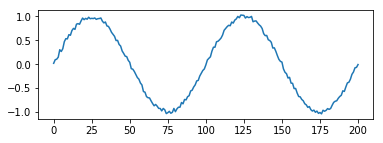

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def sin(x, T=100):
    return np.sin(2.0 * np.pi * x / T)

# sin波にノイズを付与する
def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise

f = toy_problem()
print(f.shape)
plt.figure(figsize=(6,2));plt.plot(f);plt.show()

In [3]:
def make_dataset(low_data, n_prev=100):

    data, target = [], []
    maxlen = 25

    for i in range(len(low_data)-maxlen-maxlen):
        data.append(low_data[i:i + maxlen]) # x (25フレーム切り取ってくる)
        target.append(low_data[i+1+maxlen:i +1+maxlen+maxlen]) # y (xの1~25フレーム先)

    re_data = np.array(data).reshape(len(data), maxlen, 1)
    re_target = np.array(target).reshape(len(data), maxlen)

    return re_data, re_target


#g -> 学習データ，h -> 学習ラベル
g, h = make_dataset(f)
print(g.shape, h.shape)

(151, 25, 1) (151, 25)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

# TODO: LSTMCell使う
class Model(nn.Module):
    def __init__(self, input_size=1, hidden_size=8, output_size=1):
        self.hidden_size = hidden_size
        super(Model, self).__init__()
        self.lstm = nn.LSTMCell(input_size=input_size,
                            hidden_size=hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, input): # i_0:10x1
        h_n = torch.randn(len(input), self.hidden_size)
        c_n = torch.randn(len(input), self.hidden_size)
        output = []
        for k in range(25):
            i_n = input[:,k,:]
            h_n, c_n = self.lstm(i_n, (h_n, c_n)) # 10x1, 10x8, 10x8
            o_n = self.fc(h_n) # 10x8 -> 10x1
            output.append(o_n)
        for k in range(25,50):
            i_n = output[k-25]
            h_n, c_n = self.lstm(i_n, (h_n, c_n)) # 10x1, 10x8, 10x8
            o_n = self.fc(h_n) # 10x8 -> 10x1
            output.append(o_n)
        return torch.cat(output[25:], dim=1)

In [5]:
class SinDataset(Dataset):
    def __init__(self):
        X, Y = make_dataset(f)
        self.X = np.array(X, np.float32)
        self.Y = np.array(Y, np.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [6]:
# model = Model(1, 8, 1)
# data_loader = DataLoader(SinDataset(), batch_size=10, shuffle=True)
# x,_ = iter(data_loader).next()
# print(x.shape)
# output, hidden, cell = model(x)
# output.shape, hidden.shape, cell.shape

In [7]:
model = Model(1, 8, 1)
data_loader = DataLoader(SinDataset(), batch_size=10, shuffle=True)
x,_ = iter(data_loader).next()
print(x.shape)
output = model(x)
print(output.shape)

torch.Size([10, 25, 1])
torch.Size([10, 25])


In [8]:
model = Model(1, 8, 1)

loss_fn = F.mse_loss
optim = Adam(model.parameters())

data_loader = DataLoader(SinDataset(), batch_size=10, shuffle=True)

from tqdm import tqdm
from collections import OrderedDict

with tqdm(range(0), desc="Train", ncols=10) as _tqdm:
    for epoch in _tqdm:
        
        train_loss = 0.
        train_acc = 0.
        
        for x_batch, y_batch in data_loader:
            optim.zero_grad()
            output = model(x_batch)

            loss = loss_fn(output, y_batch)
            loss.backward()
            optim.step()

            train_loss += loss.item()
            train_acc += np.sum(np.abs((output.data - y_batch.data).numpy()) < 0.1)
        
        _tqdm.set_postfix(OrderedDict(
            ep=epoch+1, 
            loss="{:.2f}".format(train_loss), 
            acc="{:.2f}".format(train_acc)))

Train: 0it [00:00, ?it/s]


In [9]:
# torch.save(model.state_dict(), "model/sample_lstm-4.pt")
model.load_state_dict(torch.load("model/sample_lstm-4.pt"))

In [10]:
# 予測
g, h = make_dataset(f)
pred = model(torch.from_numpy(np.array(g, np.float32))) # (151, 25, 1) -> (151, 25) # t+1のデータを予測したものが176個。
pred = pred.detach().numpy()
print(g.shape, pred.shape)

(151, 25, 1) (151, 25)


### Ctrl+Enter below many times!

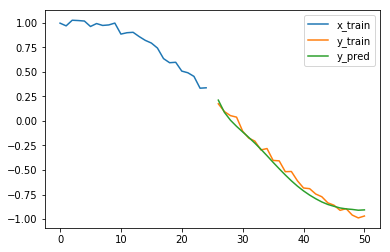

In [11]:
k = np.random.randint(len(g))
plt.plot(range(0, 25), g[k,:,0], label="x_train")
plt.plot(range(26, 51), h[k], label="y_train")
plt.plot(range(26, 51), pred[k], label="y_pred")
plt.legend()
plt.show()